In [2]:
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn import preprocessing
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from sklearn.model_selection import train_test_split
from utils.dataset import Dataset


from utils.preprocessing import *
import core.config as conf

## Load data 

In [4]:
# train_data_path = conf.dataset_path + 'part-210204-2'
train_data_path = conf.raw_lzo_path + 'part-00000'
train_df = read_data(train_data_path)

In [5]:
train_df.head()

,text_tokens,hashtags,tweet_id,media,links,domains,tweet_type,language,tweet_timestamp,creator_id,...,engager_id,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follows_engager,reply_timestamp,retweet_timestamp,comment_timestamp,like_timestamp
0,101\t56898\t137\t16925\t10731\t11481\t13980\t1...,NaN,5DCE3020423313CB0AC2631DEF94D2F5,NaN,NaN,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1613237034,BC9980C5385A68894C2862F41884FB27,...,2AEB7AFFD36CA43C0C963F24F75BCCAC,169,339,False,1520886748,False,NaN,NaN,NaN,NaN
1,101\t10159\t11322\t58550\t10836\t10126\t25900\...,NaN,2B6F5C7C4F04F34543C09DD6E58C8F66,NaN,2886BC98B8B910E86A792E56681FC841,9EFF000CDB18B710CDDB43EE1D8C300B,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,1613748600,C0EBA033A5C0D2AD91B4500958E2C633,...,865C52D28FA84E5E233B530C6FDAECC2,393,1190,False,1237570695,False,NaN,NaN,NaN,NaN
2,101\t10159\t56314\t14364\t10109\t14657\t11359\...,NaN,784D3AE5E6429392245BD34FF4C82B5C,NaN,B8FEE70DF7DA75C584F9DA8C38E99874,D56FA7843AF6F2BC53A2E192B542EA58,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,1613386238,03EA05E7440140ABF047BC216CE34917,...,FE83E568BD4B2ACDBAF876CFBB6C7296,629,1473,False,1263176351,False,NaN,NaN,NaN,1.613388e+09
3,101\t56898\t137\t10224\t10731\t64194\t41939\t3...,NaN,CA49ACBB31921F2A0FAC1CCCC99541F6,NaN,NaN,NaN,Retweet,B0FA488F2911701DD8EC5B1EA5E322D8,1613708640,2700B9E175757F126C082D6A5742787D,...,DB0201BF93E4CCA1B55932AC36923E43,123,200,False,1268276559,False,NaN,NaN,NaN,NaN
4,101\t7143\t1938\t113\t100\t10097\t100\t10097\t...,NaN,2C95B42C651B36D84584F3653D722142,Photo,NaN,NaN,TopLevel,E7F038DE3EAD397AEC9193686C911677,1612586018,B7E441F2D886830FB3F0CE29CB35CB6B,...,04F45C4A769FE2D7C792A96C92342DC2,134,379,False,1483862063,True,NaN,NaN,NaN,1.612587e+09


In [7]:
# val_data_path = conf.dataset_path + 'part-210205-2'
val_data_path = conf.raw_lzo_path + 'part-00001'
val_df = read_data(val_data_path)

In [8]:
train_df.columns

Index(['text_tokens', 'hashtags', 'tweet_id', 'media', 'links', 'domains',
       'tweet_type', 'language', 'tweet_timestamp', 'creator_id',
       'creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_account_creation', 'engager_id',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_account_creation',
       'creator_follows_engager', 'reply_timestamp', 'retweet_timestamp',
       'comment_timestamp', 'like_timestamp'],
      dtype='object')

## Parameters

In [9]:
MODEL_NAME = 'autoencoder_test'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

## Preprocessing

### dataset preprocess

In [10]:
ds = Dataset(train=True, target_encoding=False)
train_df = ds.preprocess(train_df)
val_df = ds.preprocess(val_df)

### negative samping

In [11]:
train_df

,engager_is_verified,media,creator_follows_engager,creator_id,engager_account_creation,creator_follower_count,engager_id,language,creator_following_count,tweet_id,...,tweet_type,tweet_timestamp,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
0,0,0,0,BC9980C5385A68894C2862F41884FB27,1520886748,2473,2AEB7AFFD36CA43C0C963F24F75BCCAC,19,662,5DCE3020423313CB0AC2631DEF94D2F5,...,1,1613237034,0.0,0.0,0.0,0.0,13,5,17,0
1,0,0,0,C0EBA033A5C0D2AD91B4500958E2C633,1237570695,4418640,865C52D28FA84E5E233B530C6FDAECC2,46,228,2B6F5C7C4F04F34543C09DD6E58C8F66,...,2,1613748600,0.0,0.0,0.0,0.0,19,4,15,1
2,0,0,0,03EA05E7440140ABF047BC216CE34917,1263176351,219715,FE83E568BD4B2ACDBAF876CFBB6C7296,46,3685,784D3AE5E6429392245BD34FF4C82B5C,...,2,1613386238,0.0,0.0,0.0,1.0,15,0,10,1
3,0,0,0,2700B9E175757F126C082D6A5742787D,1268276559,2388283,DB0201BF93E4CCA1B55932AC36923E43,46,13511,CA49ACBB31921F2A0FAC1CCCC99541F6,...,1,1613708640,0.0,0.0,0.0,0.0,19,4,4,0
4,0,5,1,B7E441F2D886830FB3F0CE29CB35CB6B,1483862063,414,04F45C4A769FE2D7C792A96C92342DC2,61,720,2C95B42C651B36D84584F3653D722142,...,2,1612586018,0.0,0.0,0.0,1.0,6,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033897,0,0,1,D61350A37DDC6E19AD5B1D44C607FF7D,1505241576,2230,AB51B05ACD422823A8567E51D106FBCF,48,2332,25B1D557E6B6D7298CA3888C72F9F7B5,...,1,1612804061,0.0,0.0,0.0,0.0,8,0,17,0
3033898,0,9,0,9009A33FB64F15F71D689C46FD40DA0E,1587168543,90842,2F0B0497A2C1F6DBF120782E915B1F63,19,687,3A656480D09FCCBA39B0E28FBFA64B72,...,2,1613964078,1.0,0.0,0.0,0.0,22,0,3,0
3033899,0,0,1,57F1EBC5767EA3F7CE3EEDB6EAE9B097,1336720553,608,5FFAD564CE93396A11C7951AA07D019E,19,328,E236B2359B119B2A7668FA83AC5E750B,...,1,1614124187,0.0,0.0,0.0,0.0,23,1,23,0
3033900,0,0,0,D3D9F1F6F4CCFA079891511B0818FF03,1540658011,6777417,1C3C0C32D7AEBCA253DC54EC85084951,46,888,B42CB5B47ABCCA8700686CD8F32696B6,...,2,1613329929,0.0,0.0,0.0,1.0,14,6,19,0


In [12]:
train_df_positive = train_df[train_df['like']==1]
train_df_negative = train_df[train_df['like']==0]
print(len(train_df_positive))
print(len(train_df_negative))

# train_df_positive = train_df_positive.sample(n = len(train_df_negative))
train_df_negative = train_df_negative.sample(n = len(train_df_positive))
train_df = pd.concat([train_df_positive, train_df_negative])

1207588
1826314


In [13]:
train_df.head()

,engager_is_verified,media,creator_follows_engager,creator_id,engager_account_creation,creator_follower_count,engager_id,language,creator_following_count,tweet_id,...,tweet_type,tweet_timestamp,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
2,0,0,0,03EA05E7440140ABF047BC216CE34917,1263176351,219715,FE83E568BD4B2ACDBAF876CFBB6C7296,46,3685,784D3AE5E6429392245BD34FF4C82B5C,...,2,1613386238,0.0,0.0,0.0,1.0,15,0,10,1
4,0,5,1,B7E441F2D886830FB3F0CE29CB35CB6B,1483862063,414,04F45C4A769FE2D7C792A96C92342DC2,61,720,2C95B42C651B36D84584F3653D722142,...,2,1612586018,0.0,0.0,0.0,1.0,6,5,4,0
7,0,0,0,223797E039AFAC669C3A24A43B59CD5E,1581377629,209681,0F7B9515737C440274E43E09E01FF8CF,19,141,787DEDA041736D0B55A0C15E993682C1,...,0,1614132656,0.0,0.0,0.0,1.0,24,2,2,0
9,0,0,0,02EA65880A80121A394AB9CD652D7AD6,1589197420,881,D3DE61AA5DFB88CEFBC2C9E675F40723,61,583,91DCD61A9D3BFD40D6B4D90786A62A58,...,2,1614172373,0.0,0.0,0.0,1.0,24,2,13,1
10,0,0,0,0A114052FE4DD3F5F7D2589673EC5ED8,1539973632,133933,0D07725F473577EE50C4EE831FC66D99,19,5371,C677F56B097FEBDEE580BF2CE4CBEB7C,...,2,1614027813,0.0,0.0,0.0,1.0,22,0,21,0


In [14]:
train_df.columns

Index(['engager_is_verified', 'media', 'creator_follows_engager', 'creator_id',
       'engager_account_creation', 'creator_follower_count', 'engager_id',
       'language', 'creator_following_count', 'tweet_id',
       'engager_following_count', 'engager_follower_count',
       'creator_is_verified', 'creator_account_creation', 'domains',
       'tweet_type', 'tweet_timestamp', 'reply', 'retweet', 'comment', 'like',
       'dt_day', 'dt_dow', 'dt_hour', 'len_domains'],
      dtype='object')

In [15]:
conf.target

['reply', 'retweet', 'comment', 'like']

In [16]:
used_features = ['engager_follower_count', 
                'engager_following_count', 
                'engager_is_verified', 
                'engager_account_creation', 
                'creator_follower_count', 
                'creator_following_count', 
                'creator_is_verified', 
                'creator_account_creation',
                'media',
                'domains',
                'language',
                'dt_day', 
                'dt_dow', 
                'dt_hour', 
                'len_domains']

In [17]:
X_train = train_df[used_features]
# Y_train = train_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
Y_train = train_df['like']

In [18]:
X_val = val_df[used_features]
# Y_val = val_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0) 
Y_val = val_df['like']

In [19]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5)


### scaling


In [20]:
def scaling(df_x):
    standard_scaler = preprocessing.StandardScaler()
    standard_scaler.fit(df_x.values)
    ss = standard_scaler.transform(df_x.values)
    df_x = pd.DataFrame(ss, columns = df_x.columns)
    return df_x

In [21]:
X_train = scaling(X_train)
X_val = scaling(X_val)
X_test = scaling(X_test)

In [22]:
X_train

,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follower_count,creator_following_count,creator_is_verified,creator_account_creation,media,domains,language,dt_day,dt_dow,dt_hour,len_domains
0,-0.016188,0.451959,-0.040119,-1.933324,-0.117299,0.004564,2.146180,-1.833245,-0.747940,-0.152439,0.694954,0.163908,-1.483688,-0.284583,2.677122
1,-0.066643,-0.189439,-0.040119,0.027970,-0.167253,-0.087572,-0.465944,1.117240,0.822908,-0.152960,1.488208,-1.322572,1.015460,-1.169794,-0.325842
2,-0.076733,-0.349495,-0.040119,0.894618,-0.119585,-0.105564,-0.465944,0.630757,-0.747940,-0.152960,-0.732903,1.650388,-0.484028,-1.464865,-0.325842
3,-0.044116,-0.030555,-0.040119,0.964114,-0.167146,-0.091829,-0.465944,-1.422337,-0.747940,-0.152179,1.488208,1.650388,-0.484028,0.158023,2.677122
4,-0.071841,-0.256275,-0.040119,0.526649,-0.136839,0.056956,-0.465944,0.805560,-0.747940,-0.152960,-0.732903,1.320059,-1.483688,1.338306,-0.325842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415171,-0.061954,-0.088597,-0.040119,-2.107799,-0.164754,-0.102674,2.146180,0.059618,1.451248,-0.152960,-0.732903,1.154894,1.515290,0.600629,-0.325842
2415172,-0.029541,-0.242791,-0.040119,-0.915667,-0.166091,-0.099567,-0.465944,-0.136592,-0.747940,-0.152960,0.536303,-0.827079,-0.983858,-0.579653,-0.325842
2415173,0.022952,0.201615,-0.040119,0.968742,-0.166958,-0.053701,-0.465944,1.224800,-0.747940,-0.152960,0.007467,0.329072,-0.983858,-0.579653,-0.325842
2415174,-0.046767,0.096670,-0.040119,-0.729357,-0.091097,-0.096801,-0.465944,-0.684020,0.822908,-0.152960,0.694954,1.485223,-0.983858,1.043235,-0.325842


## Model

### Encoder Layer

In [23]:

kargs = {
    'model_name': 'auto_encoder',
    'input_dim' : X_train.shape[1],
    'engager_dim' : 4,
    'creator_dim' : 4,
    'embedding_dim': 32,
    'encoder_dim': 64,
    'decoder_dim': 1
    
}


In [28]:
class AutoEncoder(tf.keras.models.Model):
    def __init__(self, **kargs):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = kargs['input_dim']
        self.engager_dim = kargs['engager_dim']
        self.creator_dim = kargs['creator_dim']
        self.embedding_dim = kargs['embedding_dim']
        self.encoder_dim = kargs['encoder_dim']
        self.decoder_dim = kargs['decoder_dim']
        
        # self.engager_embedding = tf.keras.layers.Embedding(input_dim=self.engager_dim, output_dim=self.embedding_dim)
        # self.creator_embedding = tf.keras.layers.Embedding(input_dim=self.creator_dim, output_dim=self.embedding_dim)
    se(16, activation = 'relu')
        self.creator_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.tweet_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.encoder = tf.keras.layers.Dense(8, activation = 'relu')
        # self.encoder2 = tf.keras.layers.Dense(4, activation = 'relu')
        self.decoder = tf.keras.layers.Dense(1, activation = 'relu')
    
    def call(self, x):
        # x1 = self.engager_embedding(x[:,:4])
        # x2 = self.creator_embedding(x[:,4:])
        
        x1 = self.engager_encoder(x[:,:4])
        x2 = self.creator_encoder(x[:,4:8])
        x3 = self.tweet_encoder(x[:,8:])
        x = tf.concat([x1, x2, x3], 1)
        x = self.encoder(x)
        # x = tf.concat([x, x3], 1)
        # x = self.encoder2(x)
        x = self.decoder(x)
        return x

    def summary(self):
        inputs = tf.keras.layers.Input((self.input_dim))
        tf.keras.models.Model(inputs, self.call(inputs)).summary()
    

In [29]:
model = AutoEncoder(**kargs)


In [30]:
model.summary()
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer = 'adam', # adam
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 4)            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 4)            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 7)            0           input_2[0][0]                    
____________________________________________________________________________________________

In [31]:
result = model.fit(
    x = X_train.to_numpy(),
    y = Y_train.to_numpy(),
    validation_data=(X_val.to_numpy(), Y_val.to_numpy()),
    epochs=100,
    batch_size=32
)

Epoch 1/100
75475/75475 [==============================] - 39s 510us/step - loss: 0.7025 - binary_crossentropy: 0.7025 - val_loss: 0.6742 - val_binary_crossentropy: 0.6742
Epoch 2/100
75475/75475 [==============================] - 38s 508us/step - loss: 0.6741 - binary_crossentropy: 0.6741 - val_loss: 0.6731 - val_binary_crossentropy: 0.6731
Epoch 3/100
75475/75475 [==============================] - 38s 507us/step - loss: 0.6725 - binary_crossentropy: 0.6725 - val_loss: 0.6685 - val_binary_crossentropy: 0.6685
Epoch 4/100
75475/75475 [==============================] - 38s 509us/step - loss: 0.6719 - binary_crossentropy: 0.6719 - val_loss: 0.6707 - val_binary_crossentropy: 0.6707
Epoch 5/100
75475/75475 [==============================] - 38s 509us/step - loss: 0.6711 - binary_crossentropy: 0.6711 - val_loss: 0.6655 - val_binary_crossentropy: 0.6655
Epoch 6/100
75475/75475 [==============================] - 38s 509us/step - loss: 0.6702 - binary_crossentropy: 0.6702 - val_loss: 0.6791 - 

## Evaluate

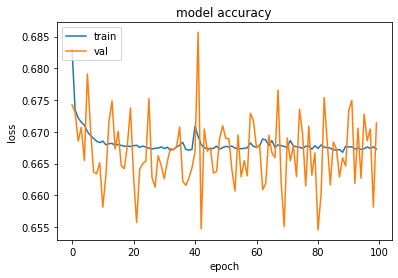

In [32]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [33]:
pred = model.predict(X_test)

In [34]:
pred.reshape(-1)

array([0.2746909 , 0.7501384 , 0.49416184, ..., 0.5209321 , 0.12342066,
       0.48787028], dtype=float32)

In [35]:
rce = compute_rce(pred.astype(np.float64), Y_test.astype(np.float64))
rce

-0.737607555765929

In [36]:
average_precision_score(Y_test, pred)

0.5110658509405345